# ERA5 Q1 Compositing

## import package

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

from matplotlib import pyplot as plt

## Load data

In [2]:
# date compute (compositing date: 2006~2017)
## setting total period of ERA5 data
date_tot = pd.date_range(start='1979-01-01', periods=15706, freq='d')

date_str: int = np.where((date_tot.year==2006))[0][0] # 2006/01/01
date_trm: int = np.where((date_tot.year==2017))[0][-1] # 2017/12/31

with nc.Dataset('/work/b11209013/2024_Research/nstcCCKW/Q1/Q1Flt.nc', 'r') as f:
    time = f['time'][date_str:date_trm+1]
    lat = f['lat'][:]
    lon = f['lon'][:]
    lev = f['lev'][:]
    q1 = f['Q1'][date_str:date_trm+1]

ltime, llev, llat, llon = q1.shape

print(q1.shape)

(4383, 38, 60, 576)


## Vertical integral

In [3]:
lev_df = np.diff(lev)[None, :, None, None]
q1_ave = (q1[:, :1]+q1[:, :-1]) / 2
q1_int = -np.sum(q1_ave * lev_df, axis=1) * 86400/2.5e6/9.8

## Bandpass filter

### Setup condition

In [4]:
wn = np.linspace(-287.5, 288, llon)
fr = np.linspace(-0.5, 0.5, ltime)

wnm, frm = np.meshgrid(wn, fr)

kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

cond = (
    (wnm >= 1) & (wnm < 14) &
    (frm >= 1/20) & (frm <= 1/2.5) &
    (frm <= kel_curves(90, wnm)) & (frm >= kel_curves(8, wnm))
)

### Apply FFT on q1_int along latitude

In [5]:
data_fft = np.stack([
    np.fft.fftshift(np.fft.fft2(q1_int[:, i, :]))[:, ::-1]
    for i in range(llat)
], axis=1)

### Bandpass filter

In [6]:
data_kel = np.stack([
    np.fft.ifft2(
        np.fft.ifftshift(np.where(cond, data_fft[:, i, :]*2, 0)[:, ::-1])
    )
    for i in range(llat)
], axis=1)

## Compute and Plot variance

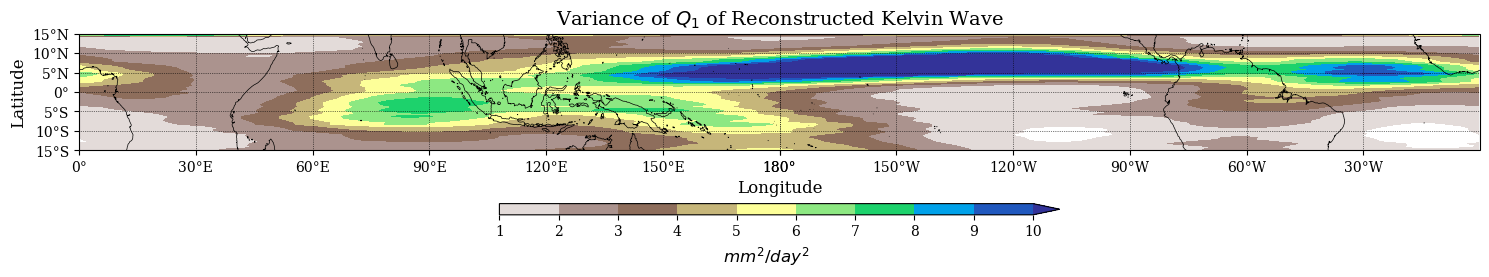

In [12]:
kel_var = data_kel.var(axis=0)

plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(
    1,
    1,
    figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)

ax.coastlines(linewidth=0.5)
ax.set_extent([-180, 180, -15, 15], crs=ccrs.PlateCarree())

c = ax.contourf(
    lon, lat, kel_var, transform=ccrs.PlateCarree(), cmap="terrain_r", extend="max",
    levels=np.linspace(1, 10, 10)
)
ax.set_xticks(np.linspace(-180, 180, 13), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-15, 15, 7), crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(r"Variance of $Q_1$ of Reconstructed Kelvin Wave")
ax.grid(color="black", linestyle=":", linewidth=0.5)
cbar = plt.colorbar(
    c, ax=ax, orientation="horizontal", label=r"$mm^2/day^2$", shrink=0.4, aspect=50
)
cbar.set_ticks(np.linspace(1, 10, 10))
plt.tight_layout()
plt.savefig('kel_var.svg')
plt.show()